In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Data Sourcing

In [2]:
from members import Members
member = Members().get_data()
member = Members().clean_data(member)

from weather import Weather
weather = Weather().get_data()
weather = Weather().clean_data(weather)

from expeds import Expeds
exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

# Dropping Columns

In [3]:
mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation','summit_claimed',
               'summit_disputed','highpt','high_point','death','death_type','death_height',
               'death_class','summit_bid','summit_term','summit_date1','citizenship',
              'o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 'yob', 'route1', 'ascent1',
              'leader', 'deputy', 'bconly', 'nottobc', 'support', 'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders','sponsor','success1','success2',
               'ascent1','claimed','disputed','countries','summit_time','term_date','term_reason', 'summit_days',
               'term_note','high_point','traverse','ski','parapente','o2_climb','o2_descent','o2_sleep','o2_medical',
               'o2_taken','o2_unkwn','o2_used','o2_none','other_smts','campsites','accidents','achievment','agency',
               'peak_name','primmem','summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')

# Merging

In [4]:
df = exped.merge(member, on='exp_id', how = 'right')

df = df.set_index('summit_date')
wet = weather.set_index('date_time')

df = df.merge(wet, how='left', left_index=True, right_index=True)

df = df.reset_index()
df.drop(columns=['exp_id', 'index', 'bc_date', 'moonrise', 'moonset', 'sunrise', 'sunset'], inplace = True)

# Data Correlation

In [11]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,tot_days,camps,rope,tot_members,tot_hired,no_hired,comrte,stdrte,primrte,peak_height,sex_M,disabled,summit_success,solo,traverse,ski,parapente,speed,o2_used,age,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
tot_days,1.000000,0.491003,0.142333,0.190612,0.313537,-0.146936,0.199105,0.529860,0.036943,0.599190,0.044874,0.003433,0.238522,-0.013423,-0.008598,-0.008792,-0.014043,-0.005664,0.520442,-0.093893,0.358925,0.439153,0.141007,0.248644,-0.306803,0.072934,0.472416,0.443643,0.444444,0.443643,-0.144631,0.310593,0.309646,0.208115,-0.471208,0.358925,-0.212333,-0.034885,-0.024457
camps,0.491003,1.000000,0.126914,0.106078,0.164017,-0.148227,0.156912,0.287563,-0.007707,0.287376,0.023582,-0.000842,0.264285,-0.008331,-0.005428,0.019034,0.005200,-0.002341,0.353290,-0.058889,0.277004,0.282331,0.059017,0.143391,-0.091048,0.036388,0.265404,0.308778,0.301244,0.308778,-0.102660,0.076368,0.075583,0.078202,-0.240969,0.277004,-0.022978,-0.148859,-0.067724
rope,0.142333,0.126914,1.000000,0.393814,0.307070,-0.084583,-0.093938,0.004049,0.029674,0.027613,0.011384,-0.014484,0.013501,-0.002293,-0.003036,-0.014495,-0.006033,-0.004536,0.042702,-0.014819,0.026008,0.046891,-0.052166,0.035657,0.029799,0.051059,0.045739,0.037896,0.042734,0.037896,-0.004709,0.009221,0.026508,-0.028590,-0.016099,0.026008,0.004172,-0.025104,0.004208
tot_members,0.190612,0.106078,0.393814,1.000000,0.694266,-0.202000,0.119914,0.093443,-0.019508,0.131114,-0.008849,-0.011464,0.060625,-0.016272,-0.006609,-0.029239,0.007083,-0.010196,0.134375,-0.030904,-0.059623,-0.054635,0.048944,-0.017971,-0.071144,0.033114,-0.000922,-0.012304,-0.038772,-0.012304,-0.085752,0.071806,0.064189,0.057927,-0.003136,-0.059623,-0.073050,-0.107944,-0.091781
tot_hired,0.313537,0.164017,0.307070,0.694266,1.000000,-0.269032,0.286553,0.309463,-0.015985,0.380923,0.040238,-0.005121,0.160785,-0.014848,-0.007264,-0.034729,0.002677,-0.010811,0.346474,-0.099005,0.004992,0.086219,0.121064,0.106863,-0.224062,-0.038030,0.141878,0.107037,0.076019,0.107037,-0.164487,0.214339,0.202570,0.114043,-0.151210,0.004992,-0.185355,-0.011475,-0.108988
no_hired,-0.146936,-0.148227,-0.084583,-0.202000,-0.269032,1.000000,-0.225447,-0.188830,0.027884,-0.203217,0.000930,0.008056,-0.121662,0.031804,0.001130,0.047663,-0.009687,0.026753,-0.243147,0.013909,-0.033252,-0.049417,-0.021583,-0.025731,0.080948,-0.033190,-0.067469,-0.065592,-0.051064,-0.065592,0.060417,-0.076814,-0.063728,-0.028312,0.069922,-0.033252,0.069397,0.015945,0.050289
comrte,0.199105,0.156912,-0.093938,0.119914,0.286553,-0.225447,1.000000,0.446762,-0.069262,0.402460,0.042113,0.009902,0.201505,-0.019219,-0.006764,-0.007119,0.005529,0.002764,0.297387,-0.091083,0.092389,0.159017,0.069168,0.030690,-0.214665,-0.068621,0.184266,0.168390,0.153123,0.168390,-0.136651,0.204720,0.174898,0.093697,-0.123507,0.092389,-0.152153,-0.069664,-0.087681
stdrte,0.529860,0.287563,0.004049,0.093443,0.309463,-0.188830,0.446762,1.000000,-0.015080,0.897621,0.051411,0.016285,0.114695,-0.021871,-0.011659,0.021180,0.001886,-0.004131,0.485852,-0.080638,0.360875,0.484392,0.242335,0.326634,-0.472530,0.066692,0.585906,0.531625,0.504639,0.531625,-0.337463,0.481086,0.483109,0.273994,-0.469740,0.360875,-0.347353,-0.103352,-0.143574
primrte,0.036943,-0.007707,0.029674,-0.019508,-0.015985,0.027884,-0.069262,-0.015080,1.000000,-0.015432,0.006969,-0.002754,-0.005353,-0.001297,-0.001005,-0.003511,-0.001230,-0.000820,-0.024463,-0.016539,-0.040674,-0.039195,0.031525,-0.019479,-0.010450,-0.025162,-0.017669,-0.021672,-0.033285,-0.021672,-0.039542,0.035282,0.023456,0.020186,0.017439,-0.040674,-0.046412,0.012155,-0.039335
peak_height,0.599190,0.287376,0.027613,0.131114,0.380923,-0.203217,0.402460,0.897621,-0.015432,1.000000,0.059520,0.012572,0.115538,-0.019505,-0.013420,0.002197,-0.001705,-0.002872,0.529483,-0.107604,0.314141,0.439012,0.251579,0.349351,-0.489200,0

# Data Preprocessing

In [5]:
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

In [16]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split


numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=2)),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3, random_state= 1)

In [17]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(df.drop(columns=['summit_success']), 
                                                                df.summit_success, 
                                                                test_size= 0.3, 
                                                                random_state= 1)

# NN Model

In [7]:
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.regularizers import l1


def initialize_model():
    
    # Model architecture
    model = Sequential()
    model.add(layers.Dropout(0.2, input_shape=(203,)))
    model.add(layers.Dense(250, activation = 'relu', activity_regularizer=l1(0.0001)))
    model.add(layers.Dense(100, activation = 'relu', activity_regularizer=l1(0.0001)))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    # Model optimization : Optimizer, loss and metric 
    model.compile(optimizer = 'adam', 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

In [17]:
%%time

from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience = 30, restore_best_weights=True)

model = initialize_model()

history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs= 300, 
                    batch_size=8,
                    verbose=0,
                   callbacks = [es])

Wall time: 1min 49s


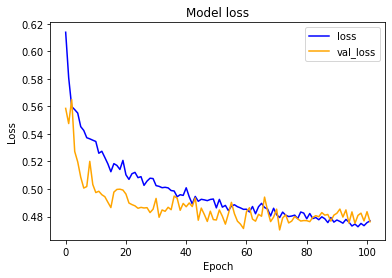

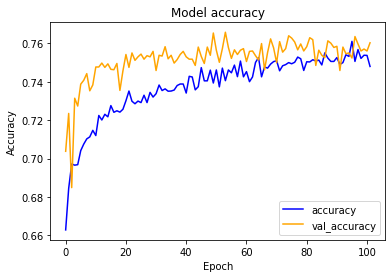

In [18]:
plt.plot(history.history['loss'], color = 'blue', label='loss')
plt.plot(history.history['val_loss'], color = 'orange', label='val_loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], color = 'blue', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'orange', label='val_accuracy')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
res = model.evaluate(X_test, y_test, verbose=0)
res[1]

0.76093590259552

In [21]:
y_pred = model.predict_classes(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.79      0.79      2837
        True       0.71      0.72      0.72      2078

    accuracy                           0.76      4915
   macro avg       0.76      0.76      0.76      4915
weighted avg       0.76      0.76      0.76      4915



## Learning Rate

In [ ]:
def optimizer_model(opt):
    
    # Model architecture
    model = Sequential()
    model.add(layers.Dropout(0.2, input_shape=(297,)))
    model.add(layers.Dense(300, activation = 'relu'))
    model.add(layers.Dense(100, activation = 'relu'))
    model.add(layers.Dense(50, activation = 'relu'))
    model.add(layers.Dense(1, activation = 'sigmoid'))
    
    # Model optimization : Optimizer, loss and metric 
    model.compile(optimizer = opt, 
                  loss = 'binary_crossentropy', 
                  metrics = ['accuracy'])
    
    return model

In [ ]:
%%time
from tensorflow.keras.optimizers import Adam

my_opt = Adam(learning_rate=0.01, name='Adam')


learning_rates = [0.0001, 0.0005, 0.001, 0.005, 0.01]

hist = []

for lr in learning_rates:
    my_opt = Adam(learning_rate= lr)
    model = optimizer_model(my_opt)
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        epochs=200,
                        batch_size=16, 
                        verbose=0, 
                        callbacks=[es])
    hist.append(history.history)

In [ ]:
def plot_loss_mae_epoch(history, n_epochs):
    plt.plot(history['loss'][n_epochs:])
    plt.plot(history['val_loss'][n_epochs:])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()
    
    plt.plot(history['accuracy'][n_epochs:])
    plt.plot(history['val_accuracy'][n_epochs:])
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='best')
    plt.show()

In [ ]:
for lr,item in zip(learning_rates,hist):
    print(lr)
    plot_loss_mae_epoch(item, 0)

## Optimizer

In [ ]:
optimizers = ['Adadelta', 'Adagrad', 'Adamax', 'Adam', 'SGD']

hist = []

for my_opt in optimizers:
    model = optimizer_model(my_opt)
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        epochs=200,
                        batch_size=16, 
                        verbose=0, 
                        callbacks=[es])
    hist.append(history.history)

In [ ]:
for opt,item in zip(optimizers,hist):
    print(opt)
    plot_loss_mae_epoch(item, 0)

## Batch Size

In [ ]:
batches = [2,4,8,16]

batch = []

for bat in batches:
    model = initialize_model()
    history = model.fit(X_train, y_train,
                        validation_split=0.3,
                        epochs=200,
                        batch_size= bat, 
                        verbose=0, 
                        callbacks=[es])
    batch.append(history.history)

In [ ]:
for bat,item in zip(batches, batch):
    print(bat)
    plot_loss_mae_epoch(item, 0)

# NN vs Xgb vs Log

In [27]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.80      0.79      0.79      2837
        True       0.71      0.72      0.72      2078

    accuracy                           0.76      4915
   macro avg       0.76      0.76      0.76      4915
weighted avg       0.76      0.76      0.76      4915



In [28]:
from xgboost import XGBClassifier

boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.85      0.82      0.84      2837
        True       0.77      0.81      0.79      2078

    accuracy                           0.82      4915
   macro avg       0.81      0.81      0.81      4915
weighted avg       0.82      0.82      0.82      4915



In [10]:
from sklearn.linear_model import LogisticRegression

log = LogisticRegression(max_iter=500)
log.fit(X_train, y_train)
ypred_log = log.predict(X_test)
print(classification_report(y_test, ypred_log))

              precision    recall  f1-score   support

       False       0.74      0.77      0.75      2837
        True       0.67      0.62      0.64      2078

    accuracy                           0.71      4915
   macro avg       0.70      0.70      0.70      4915
weighted avg       0.71      0.71      0.71      4915



# Outlier Detecttion

In [26]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)
mask = yhat == -1 # select all rows that are outliers
X_train_df[mask]

,peak_id,host,tot_days,camps,rope,tot_members,tot_hired,no_hired,comrte,stdrte,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
5837,BARU,Nepal,6,2,1700,17,7,False,False,False,...,-14.0,9.0,87.0,94.0,2.8,1015.0,-9.0,4.0,207.0,7.0
10524,HIML,Nepal,22,3,5000,72,25,False,False,False,...,-14.0,11.0,9.0,67.0,1.0,1018.0,-5.0,9.0,137.0,6.0
8250,HIML,Nepal,18,3,600,7,6,False,False,False,...,-21.0,13.0,3.0,62.0,0.0,1018.0,-8.0,10.0,175.0,10.0
2557,CHOY,China,0,2,0,20,10,False,True,True,...,-4.0,17.0,93.0,94.0,7.9,1011.0,2.0,5.0,177.0,14.0
1443,CHOY,China,0,1,0,1,0,True,True,True,...,-7.0,19.0,99.0,98.0,7.1,1016.0,0.0,3.0,212.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2669,CHOY,China,24,3,0,18,8,False,True,True,...,-4.0,12.0,100.0,96.0,15.6,1014.0,1.0,3.0,169.0,9.0
542,PUTH,Nepal,0,0,0,9,0,False,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13576,EVER,Nepal,47,2,0,36,43,False,True,True,...,-16.0,7.0,94.0,95.0,6.6,1018.0,-10.0,4.0,207.0,6.0
10820,AMAD,Nepal,11,1,1400,8,7,False,False,False,...,-20.0,17.0,4.0,55.0,0.0,1020.0,-7.0,10.0,297.0,9.0


In [27]:
from sklearn.svm import OneClassSVM

ee = OneClassSVM(nu=0.01)
yhat_2 = ee.fit_predict(X_train)
mask_2 = yhat_2 == -1 # select all rows that are outliers
X_train_df[mask_2]

,peak_id,host,tot_days,camps,rope,tot_members,tot_hired,no_hired,comrte,stdrte,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
3701,ROMA,Nepal,3,1,50,2,1,False,False,False,...,-12.0,12.0,62.0,94.0,4.9,1016.0,-4.0,4.0,228.0,8.0
13420,MAKA,Unknown,17,2,0,6,0,True,False,True,...,-18.0,9.0,59.0,88.0,1.9,1017.0,-11.0,7.0,244.0,6.0
6174,KANS,Nepal,15,6,4600,1,4,False,False,False,...,-24.0,28.0,62.0,86.0,2.7,1017.0,-11.0,7.0,214.0,22.0
9091,EVER,Nepal,35,4,6400,42,65,False,True,True,...,-7.0,12.0,52.0,89.0,1.2,1009.0,-2.0,8.0,247.0,10.0
12999,ANN1,Nepal,0,2,0,2,1,False,False,True,...,-18.0,6.0,31.0,89.0,0.9,1021.0,-9.0,4.0,228.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12984,ANN1,Nepal,49,4,0,1,1,False,False,True,...,-21.0,11.0,31.0,84.0,1.6,1017.0,-11.0,6.0,236.0,6.0
10422,PUTH,Nepal,6,2,0,7,1,False,False,False,...,-8.0,21.0,100.0,98.0,40.6,1014.0,-3.0,6.0,168.0,15.0
8583,PUMO,Nepal,11,1,300,1,3,False,False,False,...,-22.0,22.0,5.0,53.0,0.0,1020.0,-11.0,10.0,251.0,15.0
7493,SHEY,Nepal,11,0,0,4,3,False,False,False,...,-2.0,13.0,98.0,95.0,9.0,1002.0,2.0,5.0,209.0,10.0


In [31]:
OCSVM = list(X_train_df[mask_2].index)
ISO = list(X_train_df[mask].index)

In [34]:
for ind in OCSVM:
    print(ind in ISO)

False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
True
False
True
True
True
True
True
True
True
True
False
True
True
False
True
True
False
True
False
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
False
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
False


In [37]:
yhat_test = ee.predict(X_test)
mask_3 = yhat_test == -1 # select all rows that are outliers
X_test_df[mask_3]

,peak_id,host,tot_days,camps,rope,tot_members,tot_hired,no_hired,comrte,stdrte,...,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
16379,ANN1,Nepal,14,1,0,1,3,False,False,True,...,-21.0,28.0,0.0,31.0,0.0,1018.0,-6.0,10.0,231.0,18.0
7837,DOMO,India,0,0,0,2,3,False,False,False,...,-3.0,10.0,33.0,82.0,0.6,1015.0,2.0,9.0,231.0,8.0
9914,EVER,China,43,3,0,5,0,True,True,True,...,-1.0,10.0,20.0,65.0,2.4,1008.0,4.0,9.0,152.0,7.0
13421,MAKA,Unknown,17,2,0,6,0,True,False,True,...,-18.0,9.0,59.0,88.0,1.9,1017.0,-11.0,7.0,244.0,6.0
5067,CHWT,Nepal,3,0,0,9,0,True,False,False,...,-8.0,16.0,98.0,97.0,31.3,1013.0,-2.0,6.0,195.0,12.0
1892,EVER,China,0,0,0,13,33,False,True,True,...,-2.0,17.0,27.0,74.0,0.8,1013.0,6.0,9.0,277.0,12.0
10322,CHOY,China,9,3,0,4,1,False,True,True,...,-8.0,25.0,0.0,29.0,0.0,1021.0,0.0,10.0,25.0,18.0
5066,CHWT,Nepal,3,0,0,9,0,True,False,False,...,-8.0,16.0,98.0,97.0,31.3,1013.0,-2.0,6.0,195.0,12.0
10483,HIML,Nepal,22,3,5000,72,25,False,False,False,...,-14.0,11.0,9.0,67.0,1.0,1018.0,-5.0,9.0,137.0,6.0
8586,AMAD,Nepal,7,1,0,1,1,False,True,False,...,-24.0,38.0,9.0,18.0,0.0,1014.0,-7.0,10.0,242.0,23.0


In [41]:
X_test_df['outlier'] = yhat_test

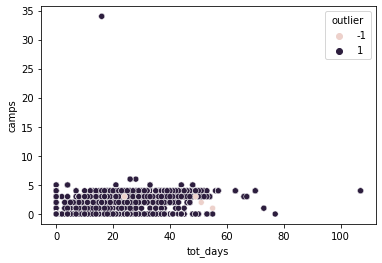

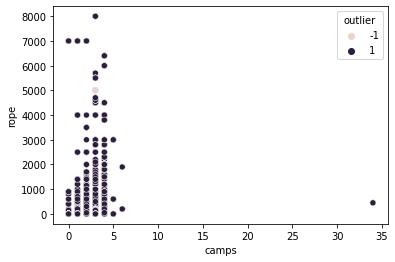

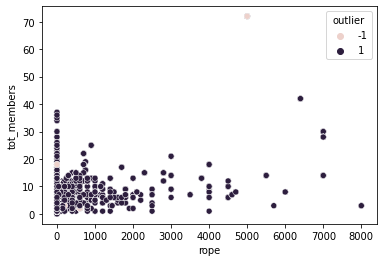

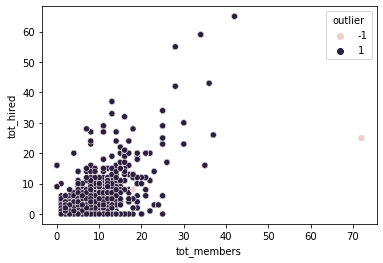

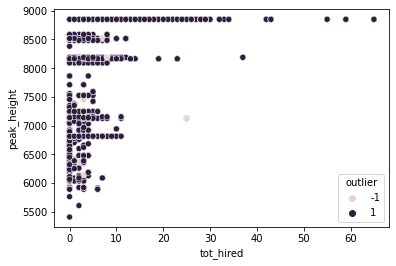

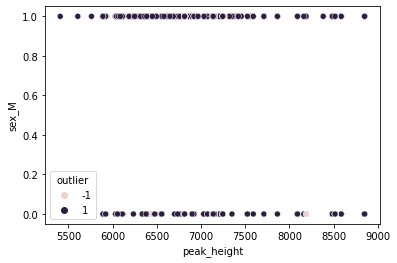

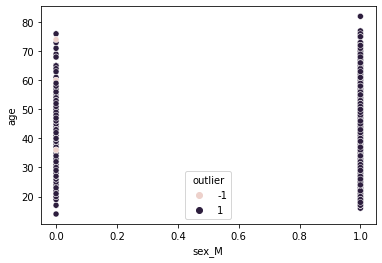

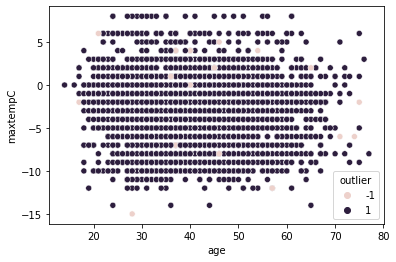

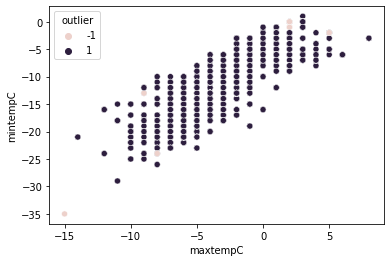

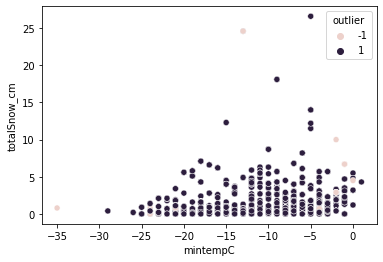

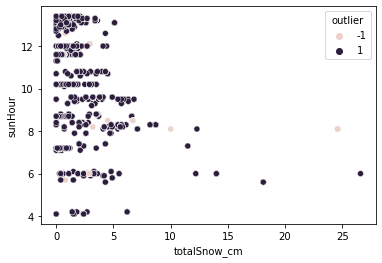

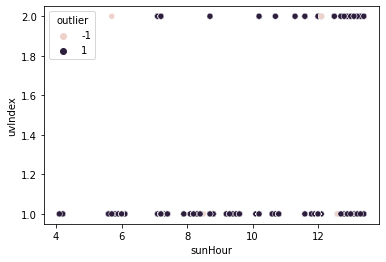

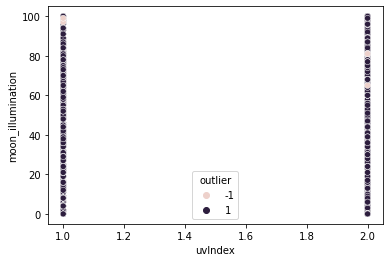

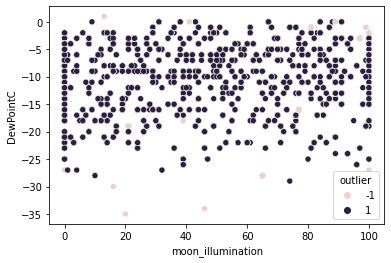

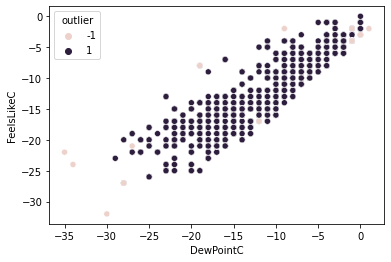

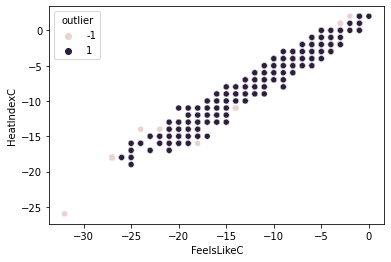

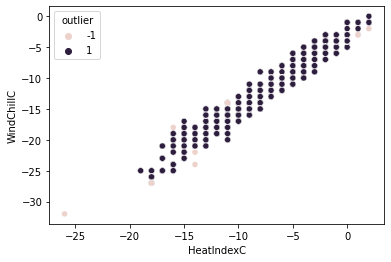

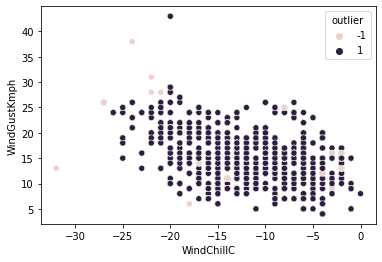

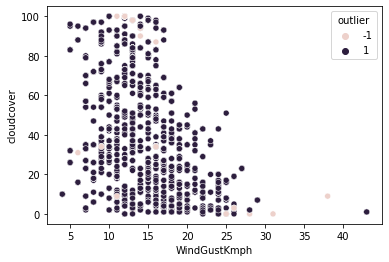

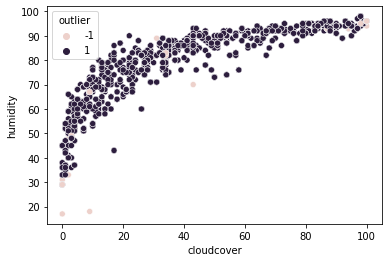

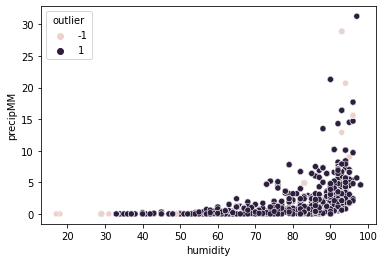

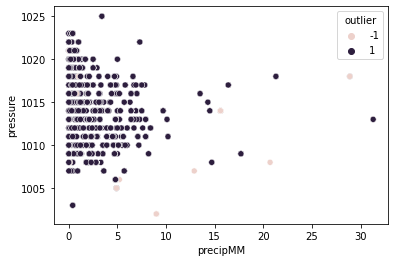

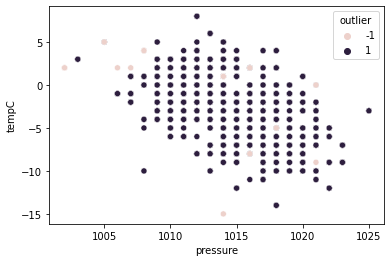

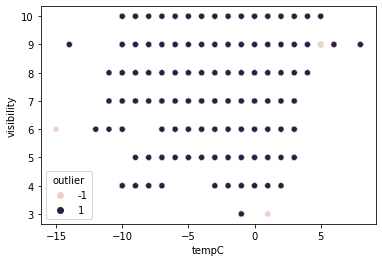

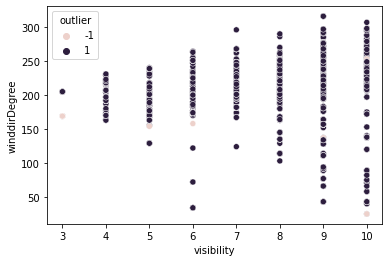

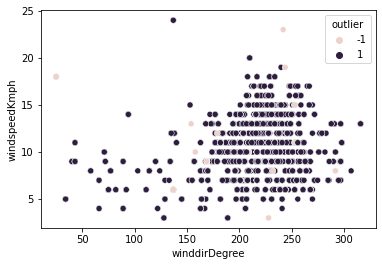

IndexError: list index out of range

In [46]:
import seaborn as sns

for i in range(len(col_num)):
    sns.scatterplot(x=col_num[i], y=col_num[i+1], hue='outlier', data=X_test_df)
    plt.show()
    

In [55]:
X_train_wet, X_test_wet = train_test_split(weather.drop(columns=['date_time','moonrise', 'moonset', 'sunrise', 'sunset']), test_size= 0.3,random_state= 1)

In [56]:
ee = OneClassSVM(nu=0.01)
yhat_2 = ee.fit_predict(X_train_wet)
mask_2 = yhat_2 == -1 # select all rows that are outliers
X_train_wet[mask_2]

,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph
3624,-14,-21,0.0,8.7,2,48,-35,-25,-18,-25,26,0,24,0.0,1023,-14,10,342,13
3477,0,-2,2.7,8.4,2,53,-1,-3,0,-3,10,85,94,5.6,1004,0,5,0,8
2273,-11,-22,0.0,12.5,2,100,-25,-27,-18,-27,29,1,52,0.0,1018,-11,10,338,18
3352,0,-31,0.0,11.6,2,3,-41,-33,-23,-33,38,0,21,0.0,1015,0,10,0,21
3332,0,-21,9.9,4.2,2,75,-19,-27,-18,-27,22,88,94,11.9,1020,0,9,0,16
3493,0,-2,5.1,8.3,2,31,-1,-2,0,-2,7,85,96,11.5,1007,0,4,0,5
2532,-6,-18,0.0,8.7,2,52,-28,-18,-13,-18,17,0,28,0.0,1021,-6,10,338,10
805,-10,-21,0.0,11.6,2,36,-26,-24,-16,-24,30,2,46,0.0,1017,-10,10,342,17
3691,-19,-31,0.0,8.7,2,100,-35,-33,-25,-33,28,9,46,0.0,1023,-19,10,340,15
1811,-14,-24,0.0,8.7,2,22,-24,-33,-21,-33,46,17,75,0.0,1025,-14,10,350,26


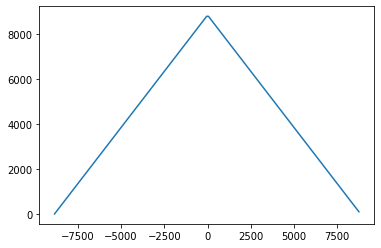

In [65]:
x = np.asarray(range(-8848, 8848, 100))
y = -abs(x) + 8848

plt.plot(x,y)

In [101]:
from members import Members
member = Members().get_data()
member = Members().clean_data(member)

mem_to_drop = ['memb_id','year','unique_id','residence','occupation','summit_claimed',
               'summit_disputed','death_class','summit_bid','summit_term','summit_date1','citizenship',
              'o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 'yob', 'route1', 'ascent1',
              'leader', 'deputy', 'bconly', 'nottobc', 'support', 'hired', 'sherpa', 'tibetan']
member.drop(columns= mem_to_drop, inplace=True)

In [102]:
dead = member[member['death']==True]
dead = dead[dead['peak_id']=='EVER']

In [103]:
y_dead = dead['death_height']

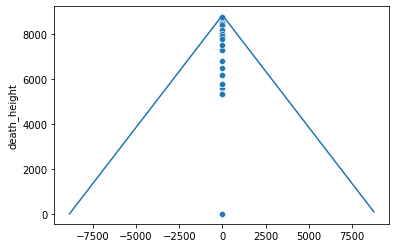

In [104]:
sns.scatterplot(x=0, y=y_dead)
plt.plot(x,y)

In [87]:
def rand_jitter(arr):
    stdev = arr.max()/100.
    return arr + np.random.randn(len(arr)) * stdev

In [105]:
x_plot = np.asarray(range(-500, 500, 100))
x_plot = np.random.choice(x_plot, len(y_dead))

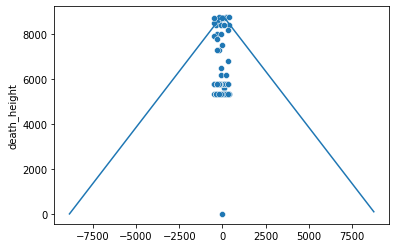

In [106]:
sns.scatterplot(x=x_plot, y=y_dead)
plt.plot(x,y)

# Leader pivot table

In [117]:
leader = Expeds().get_data()
leader = Expeds().clean_data(leader)

In [118]:
leader_to_drop = ['year','season','route1','route2','nation','sponsor','success2',
               'ascent1','claimed','disputed','countries','summit_time','term_date','term_reason', 'summit_days',
               'term_note','high_point','traverse','ski','parapente','o2_climb','o2_descent','o2_sleep','o2_medical',
               'o2_taken','o2_unkwn','o2_used','o2_none','other_smts','campsites','accidents','achievment','agency',
               'peak_name','primmem','summiter_deaths','summit_members','summit_hired','hired_deaths']

leader.drop(columns= leader_to_drop, inplace=True)

leader['summit_date'] = pd.to_datetime(leader.summit_date, errors = 'coerce')
leader['bc_date'] = pd.to_datetime(leader.bc_date , errors = 'coerce')

In [119]:
leader.head()

,exp_id,peak_id,host,leaders,success1,bc_date,summit_date,tot_days,camps,rope,tot_members,tot_hired,no_hired,comrte,stdrte,primrte,peak_height
0,TKRG10101,TKRG,Nepal,David Gottlieb,True,2010-03-06,2010-03-12,8,0,0,3,0,True,False,False,False,6771
1,AMPG10101,AMPG,Nepal,John Allen,False,2010-04-05,NaT,4,0,0,3,0,True,False,False,False,5630
2,AMAD10101,AMAD,Nepal,Orial Ribas,False,2010-04-05,2010-04-21,17,0,0,2,0,True,True,False,False,6814
3,AMAD10102,AMAD,Nepal,Dmitri Suponnikov,True,2010-04-20,2010-04-27,10,3,600,2,0,True,True,False,False,6814
4,AMAD10103,AMAD,Nepal,Sergei Kofanov,True,2010-04-04,2010-04-10,9,3,600,4,2,False,True,False,False,6814


In [116]:
len(leader.leaders.unique())

2164

In [120]:
leader.shape

(3704, 17)

In [122]:
leader.leaders

0          David Gottlieb
1              John Allen
2             Orial Ribas
3       Dmitri Suponnikov
4          Sergei Kofanov
              ...        
3699      Catherine Sarah
3700        Alan Rousseau
3701     Symon Welfringer
3702    Ang Chhiri Sherpa
3703       Juho Knuuttila
Name: leaders, Length: 3704, dtype: object

In [130]:
leader[leader['leaders'].str.contains('Sherpa')]

,exp_id,peak_id,host,leaders,success1,bc_date,summit_date,tot_days,camps,rope,tot_members,tot_hired,no_hired,comrte,stdrte,primrte,peak_height
140,TILI10301,TILI,Nepal,Ang Pemba Sherpa,False,2010-10-07,2010-10-10,4,0,800,6,2,False,False,False,False,7134
155,ANN110111,ANN1,Nepal,Mingma Sherpa,True,2010-03-15,2010-04-17,37,0,0,1,0,True,False,True,False,8091
344,EVER11137,EVER,Nepal,Chhurim Dolma Sherpa,True,2011-04-16,2011-05-12,39,3,0,1,1,False,True,True,False,8850
357,KANG11105,KANG,Nepal,Mingma Sherpa,True,2011-05-01,2011-05-20,22,3,0,1,0,True,False,True,False,8586
377,MANA10324,MANA,Nepal,Chhang Dawa Sherpa,True,NaT,2010-10-01,0,0,0,1,0,True,True,True,False,8163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3604,EVER19403,EVER,Nepal,Tashi Lakpa Sherpa,False,2020-02-24,2020-02-27,6,1,0,4,0,True,True,True,False,8850
3636,MANA19301,MANA,Nepal,Sherpa Rope-Fixing,True,2019-09-06,2019-09-24,0,4,0,1,4,False,True,True,False,8163
3666,MANA19331,MANA,Nepal,Pasang Tendi Sherpa,False,NaT,NaT,0,0,0,4,2,False,True,True,False,8163
3679,MANA19344,MANA,Nepal,Andrea Zimmermann Sherpa,False,NaT,NaT,0,0,0,2,2,False,True,True,False,8163


# Feature Engineering

In [147]:
member = Members().get_data()
member = Members().clean_data(member)

weather = Weather().get_data()
weather = Weather().clean_data(weather)

weather['rolling_pressure_past'] = weather['pressure'].rolling(window=3).mean()
weather['rolling_pressure_futur'] = weather['pressure'].shift(-2).rolling(window=3).mean()
weather['stability'] = weather['rolling_pressure_futur'] - weather['rolling_pressure_past']

exped = Expeds().get_data()
exped = Expeds().clean_data(exped)

mem_to_drop = ['memb_id','year','unique_id','peak_id','residence','occupation','summit_claimed',
               'summit_disputed','highpt','high_point','death','death_type','death_height',
               'death_class','summit_bid','summit_term','summit_date1','citizenship',
              'o2_climb','o2_descent','o2_sleep','o2_medical', 'o2_none', 'yob', 'route1', 'ascent1',
              'leader', 'deputy', 'bconly', 'nottobc', 'support', 'hired', 'sherpa', 'tibetan']


exp_to_drop = ['year','season','route1','route2','nation','leaders','sponsor','success1','success2',
               'ascent1','claimed','disputed','countries','summit_time','term_date',
               'term_note','high_point','traverse','ski','parapente','o2_climb','o2_descent','o2_sleep','o2_medical',
               'o2_taken','o2_unkwn','o2_used','o2_none','other_smts','campsites','accidents','achievment','agency',
               'peak_name','primmem','summiter_deaths','summit_members','summit_hired','hired_deaths']

member.drop(columns= mem_to_drop, inplace=True)
exped.drop(columns= exp_to_drop, inplace=True)

exped['summit_date'] = pd.to_datetime(exped.summit_date, errors = 'coerce')
exped['bc_date'] = pd.to_datetime(exped.bc_date , errors = 'coerce')

exped = exped.set_index('summit_date')
wet = weather.set_index('date_time')

In [148]:
df = exped.merge(wet, how='left', left_index=True, right_index=True)
df = df.reset_index()
df = df.rename(columns={'index' : 'summit_date'})
df = df.merge(member, on='exp_id', how = 'right')
df.drop(columns=['moonrise', 'moonset', 'sunrise', 'sunset'], inplace = True)

df.head()

,summit_date,exp_id,peak_id,host,bc_date,summit_days,tot_days,term_reason,camps,rope,...,status,disabled,summit_success,solo,traverse,ski,parapente,speed,o2_used,age
0,2010-03-12,TKRG10101,TKRG,Nepal,2010-03-06,6,8,Success_main,0,0,...,leader,False,True,False,False,False,False,False,False,43.0
1,2010-03-12,TKRG10101,TKRG,Nepal,2010-03-06,6,8,Success_main,0,0,...,bc member,False,False,False,False,False,False,False,False,39.0
2,2010-03-12,TKRG10101,TKRG,Nepal,2010-03-06,6,8,Success_main,0,0,...,climber,False,True,False,False,False,False,False,False,37.0
3,NaT,AMPG10101,AMPG,Nepal,2010-04-05,0,4,no_attempt_climb,0,0,...,leader,False,False,False,False,False,False,False,False,49.0
4,NaT,AMPG10101,AMPG,Nepal,2010-04-05,0,4,no_attempt_climb,0,0,...,climber,False,False,False,False,False,False,False,False,46.0


In [152]:
df = df.dropna(subset=['summit_date', 'bc_date'])

In [153]:
df['cumul_snow'] = 0

for index, row in df.iterrows():
    date1 = row['bc_date'].date()
    date2 = row['summit_date'].date()
    acc_snow = wet.loc[date1:date2, 'totalSnow_cm'].sum()
    df.loc[index, 'cumul_snow'] = acc_snow

c:\users\kyril\.venvs\himalaya\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\kyril\.venvs\himalaya\lib\site-packages\pandas\core\indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [156]:
df.drop(columns=['summit_date', 'exp_id', 'bc_date', 'term_reason'], inplace=True)

c:\users\kyril\.venvs\himalaya\lib\site-packages\pandas\core\frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [157]:
df

,peak_id,host,summit_days,tot_days,camps,rope,tot_members,tot_hired,no_hired,comrte,...,disabled,summit_success,solo,traverse,ski,parapente,speed,o2_used,age,cumul_snow
0,TKRG,Nepal,6,8,0,0,3,0,True,False,...,False,True,False,False,False,False,False,False,43.0,0.0
1,TKRG,Nepal,6,8,0,0,3,0,True,False,...,False,False,False,False,False,False,False,False,39.0,0.0
2,TKRG,Nepal,6,8,0,0,3,0,True,False,...,False,True,False,False,False,False,False,False,37.0,0.0
6,AMAD,Nepal,16,17,0,0,2,0,True,True,...,False,False,False,False,False,False,False,False,46.0,4.1
7,AMAD,Nepal,16,17,0,0,2,0,True,True,...,False,False,False,False,False,False,False,False,39.0,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16375,AMAD,Nepal,13,15,0,0,2,0,True,True,...,False,True,False,False,False,False,False,False,47.0,12.6
16376,AMAD,Nepal,13,15,0,0,2,0,True,True,...,False,True,False,False,False,False,False,False,41.0,12.6
16377,AMAD,Nepal,11,13,2,0,2,1,False,True,...,False,True,False,False,False,False,False,False,39.0,10.9
16378,AMAD,Nepal,11,13,2,0,2,1,False,True,...,False,False,False,False,False,False,False,False,54.0,10.9


In [158]:
col_num = []
col_bool =[]
col_object =[]

for col in df:
    if df[col].dtype == "float64":
        col_num.append(col)
        
    if df[col].dtype == "int64":
        col_num.append(col)
        
    if df[col].dtype == 'bool':
        col_bool.append(col)
        
    if df[col].dtype == 'object':
        col_object.append(col)
        
col_bool.remove('summit_success')

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split


numeric_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=2)),
    ('scaler', MinMaxScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop= 'first', handle_unknown='error'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, col_num),
        ('cat', categorical_transformer, col_object)])

clf = Pipeline(steps=[('preprocessor', preprocessor)])

X = df.drop(columns=['summit_success'])
y = df.summit_success

X_trans = clf.fit_transform(X)
X_tr = X_trans.toarray()

X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size= 0.3, random_state= 1)

In [160]:
from xgboost import XGBClassifier

boost = XGBClassifier()
boost.fit(X_train, y_train)
ypred = boost.predict(X_test)
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

       False       0.86      0.82      0.84      2290
        True       0.79      0.84      0.81      1852

    accuracy                           0.83      4142
   macro avg       0.82      0.83      0.82      4142
weighted avg       0.83      0.83      0.83      4142

